In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

In [7]:
data_dir = "./Datas/Dataset projet"

In [4]:
image_h = 180
image_w = 180
batch_s = 32

In [11]:
# Jeu d'entraînement (80% des données)
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.8,  # 20% pour le test
    subset="training",
    seed=42,  # Fixer une graine pour garder une répartition constante
    image_size=(image_h, image_w),
    batch_size=batch_s
)

# Jeu de test (20% des données)
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # Même split que pour l'entraînement
    subset="validation",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s
)

Found 41399 files belonging to 5 classes.
Using 8280 files for training.
Found 41399 files belonging to 5 classes.
Using 8279 files for validation.


Verifier les classes :

In [12]:
# Affichage des classes trouvées
class_names = test_set.class_names
print("Classes détectées :", class_names)

Classes détectées : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


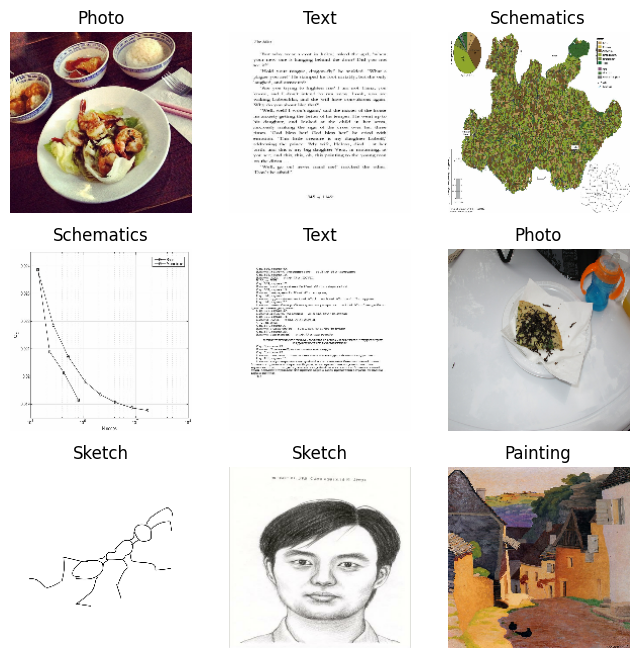

In [13]:
# Affichage des images avec leurs labels
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):  # Prend un batch du dataset
    for i in range(9):  # Afficher 9 images
        ax = plt.subplot(3, 3, i + 1)  # Crée une grille 3x3
        plt.imshow(images[i].numpy().astype("uint8"))  # Affiche l'image
        plt.title(class_names[labels[i].numpy()])  # Affiche le nom de la classe
        plt.axis("off")  # Enlève les axes
plt.show()


In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 5 # Nombre de classes et donc aussi nombre de neurones dans la dernière couche
model = Sequential()
# Normalisation des pixels entre 0 et 1
model.add(layers.Rescaling(1./255, input_shape=(180, 180, 3)))  

c:\Users\alexe\Desktop\CESI\option\env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Couche convolutive
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(180, 180, 3)))

# Couche de pooling
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Bloc convolutif de taille (32, 3)
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))

# Bloc convolutif de taille (64, 3)
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Applatissement de la couche
model.add(layers.Flatten())

# Couche entièrement connectée (Dense)
model.add(layers.Dense(128, activation='relu'))

# Couche de sortie avec un softmax pour la classification
model.add(layers.Dense(len(class_names), activation='softmax'))

In [19]:
# Compilation du modèle
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Résumé du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 39, 39, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 97344)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,460,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,498,693 (47.68 MB)

 Trainable params: 12,498,693 (47.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.5721 - loss: 0.9453 - val_accuracy: 0.7441 - val_loss: 0.5566
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 252s 970ms/step - accuracy: 0.7914 - loss: 0.5041 - val_accuracy: 0.8118 - val_loss: 0.4426
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 242s 934ms/step - accuracy: 0.8460 - loss: 0.3802 - val_accuracy: 0.8398 - val_loss: 0.3994
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 258s 996ms/step - accuracy: 0.8759 - loss: 0.3023 - val_accuracy: 0.8206 - val_loss: 0.4490
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 249s 961ms/step - accuracy: 0.9157 - loss: 0.2242 - val_accuracy: 0.8395 - val_loss: 0.4347
Epoch 6/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 253s 975ms/step - accuracy: 0.9377 - loss: 0.1828 - val_accuracy: 0.8404 - val_loss: 0.4801
Epoch 7/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 253s 978ms/step - accuracy: 0.9605 - loss: 0.1144 - val_accuracy: 0.8222 - val_loss: 0.6413
Epoch 8/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9672 - loss:

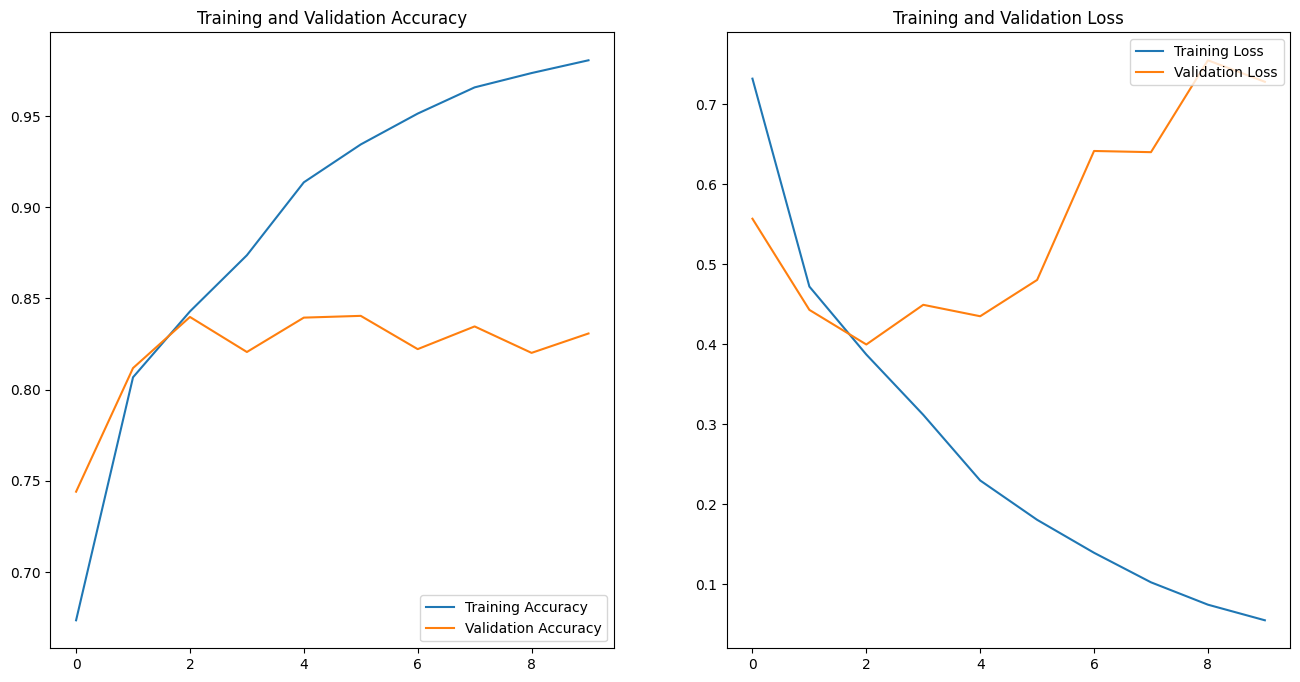

In [20]:
epochs=10
# Entraînement du modèle
history = model.fit(train_set, 
                    validation_data=test_set, 
                    epochs=epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

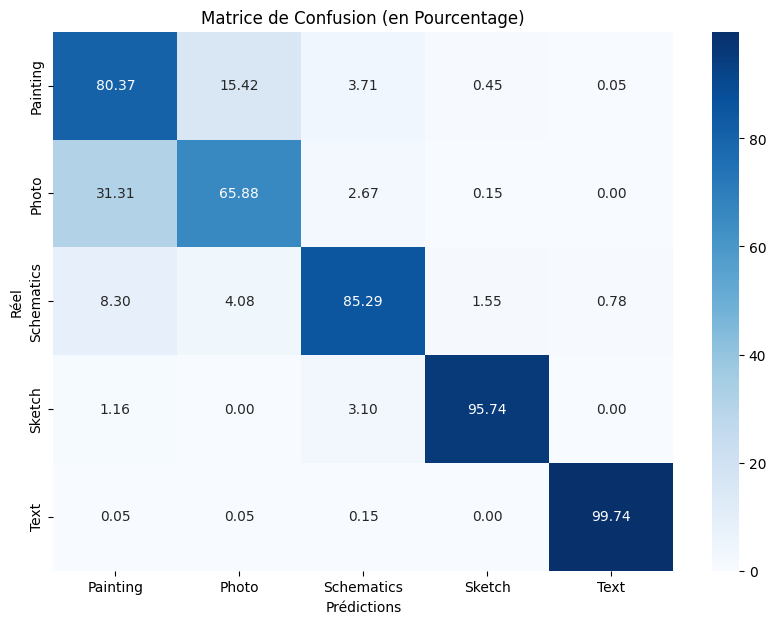

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Extraire les vraies étiquettes et les prédictions du test_set
y_true = []
y_pred = []

# itération sur les lots du jeu de test pour collecter les labels réels et les prédictions
for images, labels in test_set:
    y_true.extend(labels.numpy())  # Récupérer les labels réels
    y_pred_batch = model.predict(images)  # Faire la prédiction pour chaque lot
    y_pred.extend(np.argmax(y_pred_batch, axis=1))  # Prendre la classe prédite la plus probable

# Convertir les listes en arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Normaliser la matrice de confusion pour avoir les pourcentages
cm_percentage = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

# Vérifiez que chaque ligne somme à 100%
print(cm_percentage.sum(axis=1))

# Affichage de la matrice de confusion en pourcentage avec un heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion (en Pourcentage)')
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()


Version 2

In [22]:

# Augmentation des données
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal', input_shape=(image_h, image_w, 3)),
    layers.RandomRotation(0.18),
    layers.RandomZoom(0.1)
])




c:\Users\alexe\Desktop\CESI\option\env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 87, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 85, 85, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 462400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 462400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    59,187,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,216,613 (225.89 MB)

 Trainable params: 59,216,613 (225.89 MB)

 Non-trainable params: 0 (0.00 B)

(None, 180, 180, 3)
(None, 5)
Epoch 1/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.5497 - loss: 2.5361 - val_accuracy: 0.6529 - val_loss: 0.8439
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 588s 2s/step - accuracy: 0.6949 - loss: 0.7143 - val_accuracy: 0.6961 - val_loss: 0.7877
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - accuracy: 0.7231 - loss: 0.6404 - val_accuracy: 0.7732 - val_loss: 0.5622
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.7528 - loss: 0.5688 - val_accuracy: 0.7514 - val_loss: 0.6366
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 572s 2s/step - accuracy: 0.7895 - loss: 0.5077 - val_accuracy: 0.7155 - val_loss: 1.1737
Epoch 6/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - accuracy: 0.7980 - loss: 0.4990 - val_accuracy: 0.7343 - val_loss: 0.8616
Epoch 7/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 681s 3s/step - accuracy: 0.8226 - loss: 0.4457 - val_accuracy: 0.8134 - val_loss: 0.4929
Epoch 8/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 54419s 211s/step - accuracy

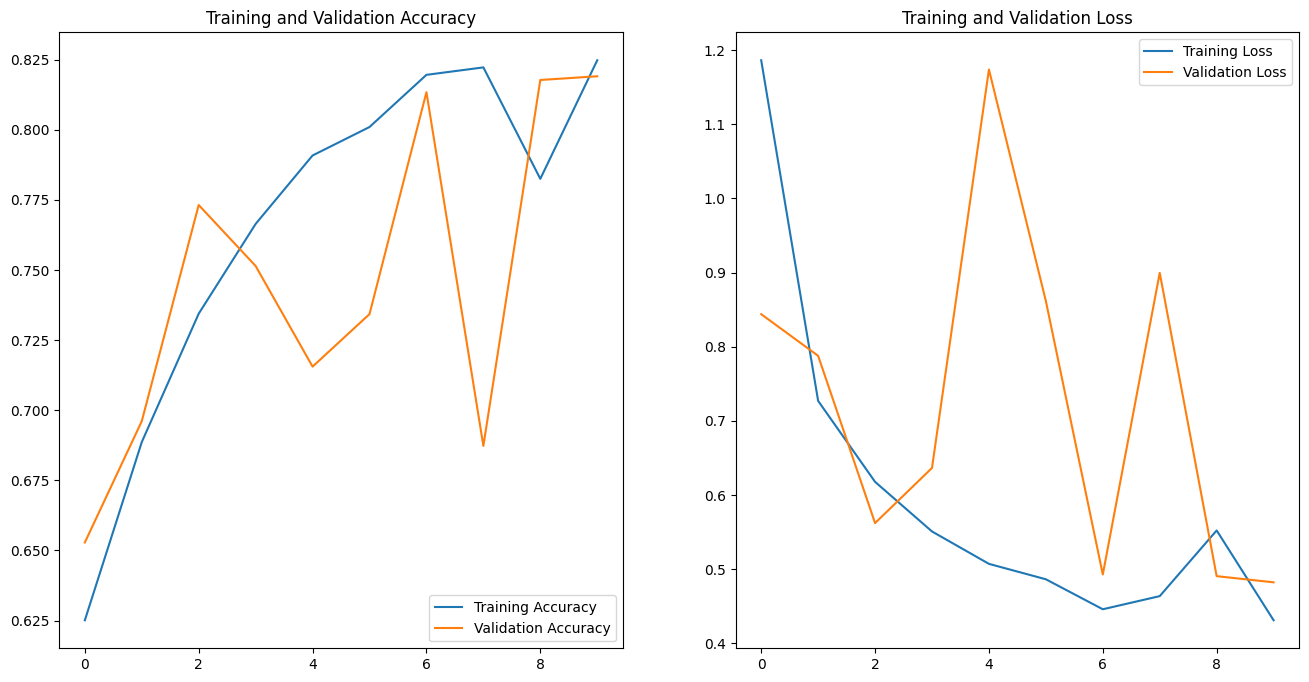

In [24]:
import datetime

epochs = 10

model_with_dropout = Sequential([
    data_augmentation,  # Ajouter l'augmentation des données
    
    layers.Rescaling(1./255),  # Normalisation des pixels
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # Classification avec softmax
])
model_with_dropout.summary()
print(model_with_dropout.input_shape)
print(model_with_dropout.output_shape)
# Compilation du modèle
model_with_dropout.compile(optimizer='adam', 
                        loss='sparse_categorical_crossentropy', 
                        metrics=['accuracy'])


history_with_dropout = model_with_dropout.fit(train_set, 
                                            validation_data=test_set, 
                                            epochs=epochs)

acc = history_with_dropout.history['accuracy']
val_acc = history_with_dropout.history['val_accuracy']

loss = history_with_dropout.history['loss']
val_loss = history_with_dropout.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

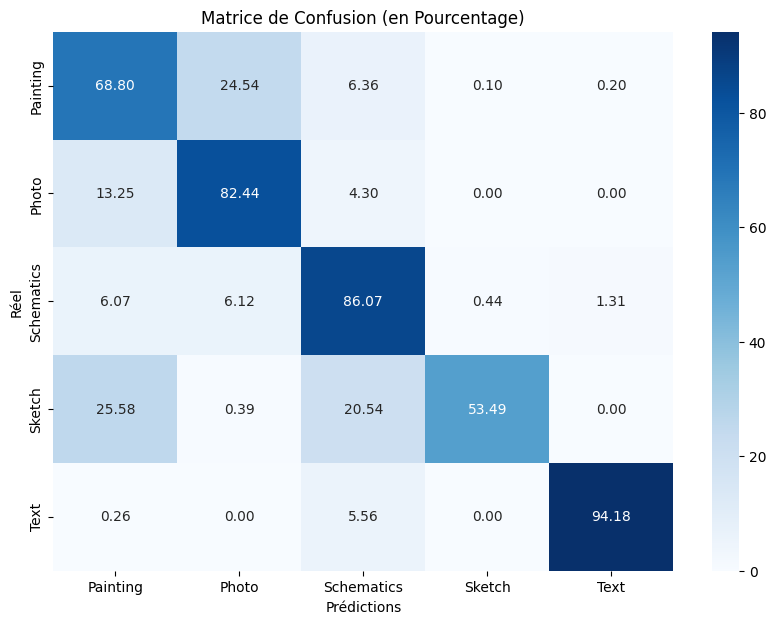

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Extraire les vraies étiquettes et les prédictions du test_set
y_true = []
y_pred = []

# itération sur les lots du jeu de test pour collecter les labels réels et les prédictions
for images, labels in test_set:
    y_true.extend(labels.numpy())  # Récupérer les labels réels
    y_pred_batch = model_with_dropout.predict(images)  # Faire la prédiction pour chaque lot
    y_pred.extend(np.argmax(y_pred_batch, axis=1))  # Prendre la classe prédite la plus probable

# Convertir les listes en arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Normaliser la matrice de confusion pour avoir les pourcentages
cm_percentage = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

# Vérifiez que chaque ligne somme à 100%
print(cm_percentage.sum(axis=1))

# Affichage de la matrice de confusion en pourcentage avec un heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion (en Pourcentage)')
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()
